In [ ]:
# !pip install kaggle

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torch import nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

print(f"Version of torch: {torch.__version__}")
print(f"Version of torchvision: {torchvision.__version__}")

Version of torch: 2.5.1+cu121
Version of torchvision: 0.20.1+cu121


In [ ]:
import os
import gc
import cv2
import copy
import time
import random
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import base64
import pickle

# For downloading images
from io import BytesIO

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp

# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, KFold

# For Image Models
import timm

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

## Dataset Creation

In [ ]:
import logging
logging.basicConfig(level=logging.INFO)

from pathlib import Path
from shutil import copyfile

In [ ]:
num_classes = 20
images_per_class = 30 # Approx

In [ ]:
description = {
    "cat": {
        "A cat is sitting on the windowsill.",
        "The cat is chasing a mouse.",
        "A cat is playing with a ball of yarn.",
        "The cat jumps onto the sofa.",
        "A black cat walks across the street.",
        "The cat is purring softly.",
        "A cat is sleeping in the sun.",
        "A white cat is grooming its fur.",
        "The cat stretches its body.",
        "A cat is hiding under the bed.",
        "A kitten is drinking milk from a bowl.",
        "The cat is scratching the door.",
        "A cat is walking through the garden.",
        "A cat is looking out the window.",
        "The cat leaps into the air.",
        "A cat is curled up in a ball.",
        "The cat is meowing loudly.",
        "A cat is rubbing against a person's leg.",
        "The cat jumps onto the table.",
        "A grey cat is hunting in the yard.",
        "The cat is chasing a feather toy.",
        "A cat is sitting in a cardboard box.",
        "The cat is licking its paws.",
        "The cat climbs a tree.",
        "A cat is curled up in a blanket.",
        "The cat plays with a laser pointer.",
        "A cat is peeking out from behind the curtain.",
        "The cat is sniffing a flower.",
        "A cat is watching birds through the window.",
        "The cat is cleaning its face.",
    },
    "chair": {
        "A chair is placed near the table.",
        "The rocking chair gently rocks back and forth.",
        "A wooden chair is by the fireplace.",
        "The chair is upholstered in soft fabric.",
        "A rocking chair sits on the porch.",
        "The chair has a comfortable cushion.",
        "A chair is placed by the window for reading.",
        "A rocking chair creaks softly.",
        "The chair is made of metal and wood.",
        "A child is sitting in the rocking chair.",
        "The chair is empty and waiting for someone.",
        "A rocking chair is on the front porch.",
        "A chair with armrests sits in the corner.",
        "The rocking chair moves slowly on the floor.",
        "The chair is painted white and looks old.",
        "A chair is beside the desk in the office.",
        "The rocking chair rocks gently on the carpet.",
        "The chair is in the living room.",
        "A comfortable rocking chair is by the fire.",
        "The chair is made of dark wood.",
        "The rocking chair has a high backrest.",
        "The chair is used for sitting and relaxing.",
        "A rocking chair sits on the balcony.",
        "A chair with a cushion is in the dining room.",
        "The rocking chair squeaks as it moves.",
        "A chair is placed in front of the TV.",
        "The rocking chair has a soft quilt on it.",
        "A chair is placed in the garden under a tree.",
        "The rocking chair sways back and forth.",
    },
    "wok": {
        "The wok is filled with sizzling vegetables.",
        "A wok on the stove with boiling soup.",
        "Food is frying in a large wok.",
        "The wok is being used to stir-fry noodles.",
        "Fresh vegetables in a hot wok.",
        "A wok is heating up on the stove.",
        "The wok is coated with a thin layer of oil.",
        "A wok is perfect for cooking stir-fries.",
        "The wok sizzles as the ingredients are added.",
        "A wok is used to cook crispy spring rolls.",
        "The wok is filled with chopped meat and sauce.",
        "A wok is a popular tool for Asian cuisine.",
        "The wok's curved shape allows for even cooking.",
        "The wok is being flipped to mix the ingredients.",
        "Hot oil is bubbling in the wok.",
        "The wok is filled with rice and vegetables.",
        "A wok is ideal for high-heat cooking.",
        "The wok creates a smoky flavor in the food.",
        "A wok is perfect for quick cooking.",
        "The wok is used to stir-fry tofu and vegetables.",
        "The wok is full of stir-fried shrimp and broccoli.",
        "A wok is placed on a high flame to heat.",
        "The wok is swirling with a stir-fry of noodles.",
        "The wok is large and deep to hold plenty of food.",
        "A wok is used to make fried rice.",
        "The wok is sizzling with spicy sauce.",
        "The wok is filled with thinly sliced meat and veggies.",
        "A wok is a versatile cooking tool for many dishes.",
        "The wok's handle is used to lift and tilt it.",
        "The wok is steaming with a savory dish.",
    },
    "candle": {
        "A single candle flickers in the darkness.",
        "The wax light glows softly on the table.",
        "A tall taper stands in a silver holder.",
        "Multiple candles are arranged in a circle.",
        "The wax light casts shadows on the wall.",
        "A red candle melts slowly onto a plate.",
        "A taper candle flickers gently by the window.",
        "The candle's flame dances in the breeze.",
        "A candle is lit in a dark room.",
        "The wax light provides a warm glow.",
        "A taper candle is placed on a dinner table.",
        "The candle is burning steadily.",
        "A wax light burns slowly in the lantern.",
        "A small candle is burning on the shelf.",
        "The taper candle is almost melted.",
        "The wax light drips down the side of the candle.",
        "A candle sits in a brass holder.",
        "The taper candle casts a soft, golden light.",
        "A candle is surrounded by fresh flowers.",
        "The wax light flickers in the breeze.",
        "A candle is placed next to a book.",
        "The taper candle illuminates the room softly.",
        "A wax light is placed in a window.",
        "The candle’s flame is steady and bright.",
        "A taper candle is lighting up the room.",
        "The wax light is in a delicate glass holder.",
        "A candle burns down, leaving wax residue.",
        "The taper is the only light in the room.",
        "The wax light is bright and calming.",
    },
    "soda-bottle": {
        "A cold soda bottle sits on the table.",
        "The coke bubbles up when poured into a glass.",
        "A soda bottle is placed in the fridge.",
        "The coke is poured into a tall glass.",
        "A soda bottle is sweating with condensation.",
        "The coke fizzles as it fills the cup.",
        "A soda bottle is opened with a pop.",
        "The coke is served with ice cubes.",
        "A soda bottle is left on the counter.",
        "The coke is being enjoyed at a party.",
        "A soda bottle is half empty.",
        "The coke is bubbling in the glass.",
        "A soda bottle is dropped by accident.",
        "The coke is sweet and refreshing.",
        "A soda bottle is rolled across the table.",
        "The coke spills over the edge of the cup.",
        "A soda bottle is placed next to a burger.",
        "The coke is poured into a metal cup.",
        "A soda bottle is tightly sealed.",
        "The coke is fizzing in the open bottle.",
        "A soda bottle is opened after a long day.",
        "The coke bottle is sitting in the sun.",
        "A soda bottle is passed around the table.",
        "The coke is served in a plastic cup.",
        "A soda bottle is set on the picnic blanket.",
        "The coke bottle is placed in a cooler.",
        "A soda bottle is filled with dark brown liquid.",
        "The coke is enjoyed with pizza.",
        "A soda bottle is clinked with a toast.",
    },
    "gazelle": {
        "A gazelle is grazing in the field.",
        "The gazelle leaps gracefully over the grass.",
        "A gazelle runs swiftly across the savannah.",
        "The gazelle is spotted near the waterhole.",
        "A gazelle is standing alert, watching its surroundings.",
        "The gazelle jumps over a small bush.",
        "A gazelle is eating leaves from a tree.",
        "The gazelle's horns are curved and elegant.",
        "A gazelle sprints away from a predator.",
        "The gazelle blends into the tall grass.",
        "A gazelle is bounding through the open plain.",
        "The gazelle moves in quick, graceful strides.",
        "A gazelle pauses to drink from the river.",
        "The gazelle is part of a large herd.",
        "A gazelle darts across the path.",
        "The gazelle's fur is tan with white markings.",
        "A gazelle watches closely for danger.",
        "A young gazelle follows its mother.",
        "The gazelle's eyes are wide and alert.",
        "A gazelle stands tall on the plains.",
        "The gazelle is swift and agile.",
        "A gazelle is racing through the open field.",
        "The gazelle grazes peacefully in the morning light.",
        "A gazelle's tail flicks in the breeze.",
        "The gazelle runs in zigzag patterns to escape predators.",
        "A gazelle stops to nibble on some grass.",
        "The gazelle's legs are long and slender.",
        "A gazelle leaps into the air.",
        "The gazelle grazes near a bush.",
    },
    "cock": {
        "The cock crows loudly at dawn.",
        "A cock struts proudly in the yard.",
        "The cock flaps its wings in the morning.",
        "A cock stands tall on the fence.",
        "The cock pecks at the ground for food.",
        "A cock's feathers are vibrant and colorful.",
        "The cock crows to announce the start of the day.",
        "A cock scratches the earth with its feet.",
        "The cock watches over the hens.",
        "A cock is perched on the barn roof.",
        "The cock puffs out its chest and crows.",
        "A cock stands in the middle of the farm.",
        "The cock chases after a hen.",
        "A cock spreads its wings wide.",
        "The cock's comb is bright red.",
        "A cock runs around the farmyard.",
        "The cock crows to wake up the farmer.",
        "A cock pecks at some grains.",
        "The cock's tail feathers are long and shiny.",
        "A cock shakes its feathers.",
        "The cock is roosting on a tree branch.",
        "The cock crows in the early morning light.",
        "A cock struts with confidence in the barn.",
        "The cock preens its feathers.",
        "A cock is seen walking proudly through the barnyard.",
        "The cock jumps up onto a perch.",
        "A cock spreads its wings and stretches.",
        "The cock walks in a circle around the yard.",
        "The cock's crow echoes across the farm.",
    },
    "kite": {
        "The kite soars high in the sky.",
        "A kite is flying on a windy day.",
        "The colorful kite flaps in the breeze.",
        "A kite is attached to a long string.",
        "The kite spins in the air.",
        "A kite is drifting over the beach.",
        "The kite's tail dances in the wind.",
        "A kite is soaring above the field.",
        "The kite climbs higher with each gust of wind.",
        "A kite is pulled by a child on the ground.",
        "The kite swoops down and then rises again.",
        "A kite glides gracefully across the sky.",
        "The kite is red with yellow stripes.",
        "A kite is stuck in the tree.",
        "The kite floats gently in the calm breeze.",
        "A kite is being flown by a family in the park.",
        "The kite dips and dives in the strong wind.",
        "A kite is tethered to a wooden spool.",
        "The kite catches the wind and rises quickly.",
        "A kite is swirling in the bright blue sky.",
        "The kite's colorful wings catch the sunlight.",
        "A kite is being launched from the beach.",
        "The kite's tail wags in the wind.",
        "A kite is fluttering above the crowd.",
        "The kite swoops low before climbing again.",
        "A kite is dancing in the sky like a bird.",
        "The kite jerks in the air as the wind picks up.",
        "A kite is gliding smoothly with no effort.",
        "The kite is carried by the wind across the horizon.",
    },
    "dinosaur": {
        "A dinosaur roars in the jungle.",
        "The triceratops has three sharp horns.",
        "A T-Rex stomps through the forest.",
        "The dinosaur's tail sways back and forth.",
        "A triceratops grazes on the prehistoric grass.",
        "The T-Rex has sharp teeth and a powerful jaw.",
        "A dinosaur walks slowly through the swamp.",
        "The triceratops defends itself with its horns.",
        "A T-Rex hunts for prey in the jungle.",
        "The dinosaur's scales shine in the sun.",
        "A triceratops stands protectively over its young.",
        "The T-Rex lets out a loud, terrifying roar.",
        "A dinosaur lays eggs in the sand.",
        "The triceratops has a large frill around its neck.",
        "A T-Rex charges at its prey.",
        "The dinosaur's footprint is large and deep.",
        "A triceratops moves cautiously through the trees.",
        "The T-Rex is the king of the dinosaurs.",
        "A dinosaur's roar echoes through the valley.",
        "The triceratops uses its horns to push away threats.",
        "A T-Rex looks over its territory from a high rock.",
        "The dinosaur’s body is covered with rough skin.",
        "A triceratops walks on four sturdy legs.",
        "The T-Rex hunts in packs with other predators.",
        "A dinosaur roams freely across the plains.",
        "The triceratops eats plants and leaves.",
        "The T-Rex runs quickly across the land.",
        "A dinosaur’s teeth are sharp for tearing food.",
        "The triceratops moves in a slow and steady pace.",
    },
    "basketball": {
        "The basketball bounces on the court.",
        "A player dribbles the basketball down the lane.",
        "The basketball flies through the hoop.",
        "The basketball is passed to a teammate.",
        "A basketball game is happening on the court.",
        "The basketball spins in the air.",
        "The player jumps to make a slam dunk.",
        "The basketball is dribbled with quick movements.",
        "A basketball is thrown from the three-point line.",
        "The basketball team celebrates a win.",
        "A basketball is bouncing across the floor.",
        "The player shoots the basketball with precision.",
        "A basketball is passed behind the back.",
        "The basketball rolls towards the sideline.",
        "The basketball is grabbed by the rebounder.",
        "The basketball court is full of players.",
        "The basketball swishes through the net.",
        "A basketball is dribbled through the defense.",
        "The basketball is thrown for a fast break.",
        "The basketball team lines up for a free throw.",
        "A player dribbles past an opponent.",
        "The basketball spins off the rim.",
        "A basketball is bounced before the shot.",
        "The basketball is caught with one hand.",
        "The basketball is bounced against the wall.",
        "A basketball player jumps for the rebound.",
        "The basketball is moved quickly between players.",
        "The basketball rolls across the court.",
        "The basketball is shot with a high arc.",
    },
    "canoe": {
        "The canoe floats gently on the lake.",
        "A person paddles the canoe through the water.",
        "The canoe glides across the calm river.",
        "The canoe is filled with camping gear.",
        "A canoe is tied to a tree by the shore.",
        "The canoe tips slightly as it moves forward.",
        "The canoe is paddled by two people.",
        "A canoe drifts along the peaceful waterway.",
        "The canoe is launched from the dock.",
        "A canoe rests upside down on the shore.",
        "The canoe slides silently through the misty morning.",
        "The canoe is paddled through the narrow stream.",
        "A canoe is floating near the edge of the forest.",
        "The canoe rocks gently with each paddle stroke.",
        "A canoe is pulled onto the sandy beach.",
        "The canoe moves swiftly down the river.",
        "A canoe is steered around the bend.",
        "The canoe is carefully balanced in the water.",
        "A canoe rests on the calm lake surface.",
        "The canoe is filled with passengers and supplies.",
        "A canoe is paddled in the early morning light.",
        "The canoe floats past lily pads on the water.",
        "A canoe is pulled along by the current.",
        "The canoe is maneuvered between rocks in the river.",
        "The canoe is launched into the lake at sunrise.",
        "A canoe is parked on the dock after the trip.",
        "The canoe is paddled with steady strokes.",
        "A canoe drifts silently under the stars.",
        "The canoe is carried on a shoulder to the water.",
    },
    "wallclock": {
        "The wall clock ticks quietly in the room.",
        "The clock strikes twelve at midnight.",
        "A wall clock hangs on the kitchen wall.",
        "The clock shows the time in bold numbers.",
        "The wall clock chimes every hour.",
        "The clock's hands move slowly towards midnight.",
        "A wall clock is placed above the fireplace.",
        "The clock has a golden frame around it.",
        "A wall clock is ticking steadily in the hallway.",
        "The clock's alarm rings loudly in the morning.",
        "A wall clock shows the exact time at noon.",
        "The clock is broken and no longer works.",
        "A wall clock is placed in the living room.",
        "The clock has a vintage design with Roman numerals.",
        "The wall clock is ticking faster than usual.",
        "The clock's battery needs to be replaced.",
        "A wall clock reflects light from the window.",
        "The clock shows a different time zone.",
        "A wall clock is hung in the office.",
        "The clock's minute hand moves quickly.",
        "A wall clock is ticking louder than usual.",
        "The clock is mounted on the wall above the door.",
        "A wall clock makes a soft ticking noise.",
        "The clock's hands are pointing to three o'clock.",
        "A wall clock is set to the correct time.",
        "The clock is showing the time in military format.",
        "A wall clock is decorated with colorful patterns.",
        "The clock is placed on the mantel above the fireplace.",
        "The wall clock shows the time in digital format.",
    },
    "washing-machine": {
        "The washing machine is running a cycle.",
        "A washer is filled with clothes and detergent.",
        "The washing machine spins quickly to remove water.",
        "The washer beeps when the load is finished.",
        "The washing machine is quiet while operating.",
        "A washer is placed in the laundry room.",
        "The washing machine agitates the clothes in the drum.",
        "A washer is unloading clean clothes.",
        "The washing machine is loaded with dirty laundry.",
        "The washer's door is open for loading clothes.",
        "The washing machine's drum rotates during the wash.",
        "The washer is washing a load of towels.",
        "The washing machine rinses the clothes with water.",
        "A washer is working through a heavy load of laundry.",
        "The washing machine fills with water to start the cycle.",
        "The washer shakes as it spins the clothes dry.",
        "The washing machine is placed next to the dryer.",
        "A washer is used for cleaning clothes.",
        "The washing machine has a delicate cycle for fabrics.",
        "The washer finishes its spin cycle with a final buzz.",
        "The washing machine agitates the soap into the clothes.",
        "A washer drains water after the wash cycle.",
        "The washing machine is ready to be emptied.",
        "A washer washes a variety of clothing items.",
        "The washing machine is designed to clean efficiently.",
        "The washer's lid is open as clothes are added.",
        "A washing machine is connected to the water supply.",
        "The washer uses cold water for washing delicate clothes.",
        "The washing machine is vibrating as it spins.",
    },
    "violin": {
        "The violin plays a sweet, high-pitched note.",
        "A fiddle is being tuned before the performance.",
        "The violinist's bow moves quickly across the strings.",
        "The fiddle creates a lively, rhythmic sound.",
        "A violin is held under the chin while playing.",
        "The violin’s sound fills the concert hall.",
        "A fiddle is played at a country music festival.",
        "The violin's strings are adjusted for perfect pitch.",
        "A violin's bow dances across the strings.",
        "The fiddle's tone is bright and cheerful.",
        "A violin is stored carefully in its case.",
        "The fiddle player taps their foot to the rhythm.",
        "The violin produces a beautiful, resonating sound.",
        "The fiddle is passed between two musicians.",
        "A violinist plays a soft, slow melody.",
        "The fiddle's wood gleams in the stage lights.",
        "A violinist plays a complicated piece with ease.",
        "The fiddle is used in both classical and folk music.",
        "A violin's bridge supports the strings above the body.",
        "The violin’s bow is made of horsehair.",
        "The fiddle is a popular instrument in bluegrass bands.",
        "A violin is played with great emotion.",
        "The fiddle’s music brings joy to the crowd.",
        "The violin’s sound resonates through the room.",
        "A fiddle is often seen at a barn dance.",
        "The violin is carefully tuned before the orchestra starts.",
        "The fiddle player’s fingers move swiftly over the strings.",
        "The violin creates a soothing and gentle tone.",
        "A fiddle is commonly used in traditional folk music.",
    },
    "comic-book": {
        "The comic book is filled with colorful illustrations.",
        "A comic book character jumps across the page.",
        "The comic book has a hero on the cover.",
        "The comic book tells an exciting adventure story.",
        "A comic book is placed on the coffee table.",
        "The comic book pages flip quickly in the wind.",
        "A comic book is stacked on the bookshelf.",
        "The comic book has speech bubbles with dialogue.",
        "A comic book character battles a villain.",
        "The comic book is filled with action scenes.",
        "A comic book is read by a child on the couch.",
        "The comic book pages are turning with ease.",
        "A comic book character saves the day.",
        "The comic book is full of colorful panels.",
        "A comic book is collected by fans.",
        "The comic book is filled with superpowers and drama.",
        "The comic book's pages show the hero in action.",
        "A comic book is read under a tree on a sunny day.",
        "The comic book's hero has a cape and mask.",
        "A comic book features a mysterious villain.",
        "The comic book’s cover is eye-catching and bold.",
        "The comic book’s hero faces a tough challenge.",
        "A comic book is shared among friends.",
        "The comic book has a collection of short stories.",
        "A comic book character is running at full speed.",
        "The comic book’s storyline keeps the reader engaged.",
        "A comic book character flies through the sky.",
        "The comic book is filled with thrilling moments.",
        "A comic book is flipped through eagerly for the next chapter.",
    },
    "crossword-puzzle": {
        "The crossword puzzle is lying on the table.",
        "A pencil is used to fill in the crossword.",
        "The crossword puzzle has challenging clues.",
        "The crossword is solved one word at a time.",
        "The crossword puzzle has black and white squares.",
        "A crossword puzzle book is open on the desk.",
        "The crossword puzzle is partially completed.",
        "The crossword clues are written in small text.",
        "The crossword puzzle is a great way to pass time.",
        "A crossword is filled with both short and long answers.",
        "The crossword puzzle answers are revealed gradually.",
        "A crossword is a test of vocabulary and knowledge.",
        "The crossword puzzle grid has numbered boxes.",
        "The crossword is completed with a satisfying click.",
        "A crossword puzzle is often found in the newspaper.",
        "The crossword puzzle has both across and down clues.",
        "A pencil eraser is used to correct crossword mistakes.",
        "The crossword puzzle is challenging but fun.",
        "A crossword book is tucked in a bag for a trip.",
        "The crossword is solved during a relaxing afternoon.",
        "A crossword puzzle is a popular hobby for many.",
        "The crossword clues lead to hidden words.",
        "The crossword puzzle book is filled with different themes.",
        "The crossword puzzle has a mixture of easy and hard clues.",
        "A crossword is a good exercise for the brain.",
        "The crossword puzzle is a favorite activity in the morning.",
        "The crossword is filled with obscure trivia.",
        "A crossword puzzle can be done solo or in a group.",
        "The crossword puzzle requires patience and focus.",
    },
    "monkey": {
        "The monkey swings from tree to tree.",
        "A monkey is eating a banana.",
        "The monkey is jumping on the branches.",
        "A monkey's tail is wrapped around a tree branch.",
        "The monkey climbs up the tall tree.",
        "A monkey sits on a rock and looks around.",
        "The monkey plays with its reflection in the water.",
        "A monkey swings through the jungle vines.",
        "The monkey is holding a twig in its hand.",
        "A monkey chases after another in the jungle.",
        "The monkey jumps onto a higher branch.",
        "A monkey is grooming another monkey.",
        "The monkey is hanging upside down from a branch.",
        "A monkey yawns and stretches in the sun.",
        "The monkey makes playful noises.",
        "A monkey is watching people from a distance.",
        "The monkey sits on a branch, eating fruit.",
        "The monkey uses its hands to pick up food.",
        "A monkey plays in the leaves on the ground.",
        "The monkey's eyes are bright and curious.",
        "A monkey is climbing down the tree.",
        "The monkey hangs from a tree by its tail.",
        "A monkey shakes a tree branch.",
        "The monkey leaps from one branch to another.",
        "A monkey is sitting on the ground and eating.",
        "The monkey looks for insects on the tree bark.",
        "A monkey jumps excitedly in the forest.",
        "The monkey's tail balances it as it moves.",
        "A monkey peers through the leaves in the jungle.",
    },
    "elephant": {
        "The elephant walks slowly through the savannah.",
        "An elephant flaps its large ears to cool off.",
        "The elephant uses its trunk to grab food.",
        "An elephant trumpets loudly across the plain.",
        "The elephant drinks water from the river.",
        "An elephant walks beside its herd.",
        "The elephant's trunk swings as it walks.",
        "An elephant lifts its trunk to sniff the air.",
        "The elephant digs for water with its tusks.",
        "An elephant splashes water onto its back.",
        "The elephant is eating grass in the field.",
        "The elephant's ears are flapping in the heat.",
        "An elephant moves gracefully despite its size.",
        "The elephant sprays dust over its body.",
        "An elephant's tusks glisten in the sunlight.",
        "The elephant strolls through the jungle.",
        "The elephant steps softly on the ground.",
        "An elephant is watching the landscape.",
        "The elephant's large feet leave deep prints in the mud.",
        "The elephant raises its trunk to greet another.",
        "An elephant is resting under a tree.",
        "The elephant uses its trunk to pick up a branch.",
        "An elephant's massive body moves through the forest.",
        "The elephant digs with its tusks to reach food.",
        "An elephant swings its trunk playfully.",
        "The elephant is bathing in the river.",
        "An elephant gathers with its herd near water.",
        "The elephant’s trunk curls around a tree branch.",
        "An elephant walks through the tall grass.",
    },
    "gorilla": {
        "The gorilla sits on the ground and looks around.",
        "A gorilla beats its chest loudly.",
        "The gorilla swings from branch to branch.",
        "A gorilla eats leaves from a tree.",
        "The gorilla rests in the shade of a tree.",
        "A gorilla watches curiously from the jungle.",
        "The gorilla moves slowly across the ground.",
        "A gorilla grunts as it moves through the forest.",
        "The gorilla holds a twig in its hand.",
        "A gorilla is grooming another gorilla.",
        "The gorilla plays with its young in the jungle.",
        "A gorilla climbs up the tree to get fruit.",
        "The gorilla digs through the dirt for food.",
        "A gorilla sits with its arms crossed.",
        "The gorilla stares intensely at its surroundings.",
        "A gorilla swings through the trees with ease.",
        "The gorilla has large, strong arms.",
        "A gorilla eats fruit from a tree branch.",
        "The gorilla walks upright like a human.",
        "A gorilla rests on a large rock.",
        "The gorilla makes deep vocalizations.",
        "A gorilla roars loudly to assert its presence.",
        "The gorilla's eyes are calm and focused.",
        "A gorilla watches as other animals pass by.",
        "The gorilla moves with powerful, deliberate steps.",
        "A gorilla is holding a branch in its hand.",
        "The gorilla stands tall and looks over the jungle.",
        "A gorilla spends time in the dense forest.",
        "The gorilla is sitting in the grass, watching.",
    },
    "bus": {
        "The bus drives down the street.",
        "A bus stops at the traffic light.",
        "The bus picks up passengers at the station.",
        "A bus is parked by the sidewalk.",
        "The bus door opens for passengers to get on.",
        "The bus is moving through the city.",
        "A bus waits at the bus stop.",
        "The bus is filled with people during rush hour.",
        "The bus honks its horn as it turns the corner.",
        "A bus pulls away from the station.",
        "The bus has large windows for passengers to look out.",
        "A bus driver is sitting at the front wheel.",
        "The bus drives past a crowded street.",
        "A bus crosses the busy intersection.",
        "The bus stops to let people off.",
        "A yellow school bus picks up children.",
        "The bus travels along the highway.",
        "A bus driver opens the door for passengers to board.",
        "The bus moves slowly in traffic.",
        "The bus is heading towards downtown.",
        "A bus is parked in a parking lot.",
        "The bus is clean and well-maintained.",
        "The bus has a route number displayed in the front window.",
        "The bus goes to multiple destinations throughout the city.",
        "A bus is passing by a quiet neighborhood.",
        "The bus slows down to make a turn.",
        "A bus driver waits for passengers to board.",
        "The bus stops near a busy shopping center.",
        "The bus speeds up on the highway.",
    },
}


In [ ]:
CONFIG = {"seed": 69,
          "epochs": 25,
          "img_size": 128,
          "embedding_size": 1024,
          "train_batch_size": 32,
          "valid_batch_size": 32,
          "learning_rate": 1e-4,
          "scheduler": 'CosineAnnealingLR',
          "T_max": 15,                                      # matching this to number of epochs for good performance
          "weight_decay": 1e-6,
          "max_length": 32,
          "n_accumulate": 1,
          "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
          }


In [ ]:
CONFIG

{'seed': 69,
 'epochs': 25,
 'img_size': 128,
 'embedding_size': 1024,
 'train_batch_size': 32,
 'valid_batch_size': 32,
 'learning_rate': 0.0001,
 'scheduler': 'CosineAnnealingLR',
 'T_max': 15,
 'weight_decay': 1e-06,
 'max_length': 32,
 'n_accumulate': 1,
 'device': device(type='cpu')}

In [ ]:
def set_seed(seed=69):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.deterministic = True                   # To get deterministic results every time (makes training slower)
    torch.backends.cudnn.benchmark = False                      # To get consistent results, though not the best performance

    os.environ['PYTHONHASHSEED'] = str(seed)                    # Set a fixed value for the hash seed

set_seed(CONFIG['seed'])

## Dataset Creation

In [ ]:
from transformers import AutoProcessor, AutoModel, AutoTokenizer

In [ ]:
import zipfile

images_folder_zip = '/content/drive/MyDrive/all_images_zip.zip'
extract_folder = '/content/drive/MyDrive/text_image_folder'

if not os.path.exists(extract_folder):
    os.makedirs(extract_folder)

with zipfile.ZipFile(images_folder_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print(f"Files extracted to path: {extract_folder}/all_images")

Files extracted to path: /content/drive/MyDrive/text_image_folder/all_images


In [ ]:
from transformers import AutoTokenizer, ViTImageProcessor
from PIL import Image
import torch

class ModelDataset(Dataset):
    def __init__(self, data, tokenizer, image_processor, max_length):
        self.paired_data = data
        self.tokenizer = tokenizer
        self.image_processor = image_processor
        self.max_length = max_length

    def __len__(self):
        return len(self.paired_data)

    def __getitem__(self, index):
        data_point = self.paired_data[index]

        # Load and preprocess image
        image_path = data_point["image_path"]
        try:
            image = Image.open(image_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            return None

        # Preprocess the image for ViT
        image = self.image_processor(images=image, return_tensors="pt")["pixel_values"].squeeze(0)

        # Tokenize description
        description = data_point["description"]
        inputs = self.tokenizer.encode_plus(
            description,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_length,
            padding="max_length",
            return_tensors="pt"
        )

        ids = inputs["input_ids"].squeeze(0)                          # Remove batch dimension
        mask = inputs["attention_mask"].squeeze(0)

        # Get target label
        target = data_point["target"]

        return {
            "ids": torch.tensor(ids, dtype=torch.long),
            "mask": torch.tensor(mask, dtype=torch.long),
            "image": image,
            "target": torch.tensor(target, dtype=torch.long),
            "caption": description
        }


In [ ]:
images_folder = '/content/drive/MyDrive/text_image_folder/all-images'

image_data = []

# Loop through the folders (classes) in the images folder
for class_folder in os.listdir(images_folder):
    class_path = os.path.join(images_folder, class_folder)

    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path):

            if image_name.endswith(('.jpg', '.jpeg', '.png')):      # fitering throught extensions
                image_data.append({
                    'image_name': f'{images_folder}/{class_folder}/{image_name}',
                    'label': class_folder
                })

df = pd.DataFrame(image_data)

csv_path = '/content/drive/MyDrive/image_labels.csv'
df.to_csv(csv_path, index=False)

print(f"CSV file created at: {csv_path}")

CSV file created at: /content/drive/MyDrive/image_labels.csv


In [ ]:
df.tail()

image_name label
561  /content/drive/MyDrive/text_image_folder/all-i...   wok
562  /content/drive/MyDrive/text_image_folder/all-i...   wok
563  /content/drive/MyDrive/text_image_folder/all-i...   wok
564  /content/drive/MyDrive/text_image_folder/all-i...   wok
565  /content/drive/MyDrive/text_image_folder/all-i...   wok

### Prepare dataset witt positive and negative samples

In [ ]:
data = []
positive_count = 0
negative_count = 0

# Loop through each image in the dataframe
for _, row in df.iterrows():
    label = row['label']
    image_name = row['image_name']
    image_path = os.path.join(images_folder, label, image_name)

    positive_samples = description.get(label, [])
    for desc in positive_samples:
        data.append({
            "image_path": image_path,
            "label": label,
            "description": desc,
            "target": 1                                         # Positive match
        })
        positive_count += 1

    other_classes = [k for k in description.keys() if k != label]
    negative_descriptions = [desc for cls in other_classes for desc in description[cls]]

    for _ in range(positive_count - negative_count):           # We need equal negative samples
        neg_desc = random.choice(negative_descriptions)
        data.append({
            "image_path": image_path,
            "label": label,
            "description": neg_desc,
            "target": -1                                       # Negative match
        })
        negative_count += 1

print("Total samples in data:", len(data))
print("Positive samples:", positive_count)
print("Negative samples:", negative_count)


Total samples in data: 31320
Positive samples: 15660
Negative samples: 15660


In [ ]:
random.seed(69)
random.shuffle(data)                                          # Shuffle the dataset

train_size = int(0.7 * len(data))                             # Train: 70%
val_size = int(0.2 * len(data))                               # Validation: 20%
test_size = len(data) - train_size - val_size                 # Test: 10%

train_data = data[:train_size]
val_data = data[train_size:train_size + val_size]
test_data = data[train_size + val_size:]

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Test samples: {len(test_data)}")

Training samples: 21924
Validation samples: 6264
Test samples: 3132


In [ ]:
test_data[:10]

[{'image_path': '/content/drive/MyDrive/text_image_folder/all-images/soda-bottle/image_9.jpeg',
  'label': 'soda-bottle',
  'description': 'A wall clock is ticking steadily in the hallway.',
  'target': -1},
 {'image_path': '/content/drive/MyDrive/text_image_folder/all-images/wallclock/image_11.jpeg',
  'label': 'wallclock',
  'description': 'The clock is mounted on the wall above the door.',
  'target': 1},
 {'image_path': '/content/drive/MyDrive/text_image_folder/all-images/cock/image_27.jpeg',
  'label': 'cock',
  'description': 'The cock crows in the early morning light.',
  'target': 1},
 {'image_path': '/content/drive/MyDrive/text_image_folder/all-images/washing-machine/image_14.jpeg',
  'label': 'washing-machine',
  'description': 'A player dribbles past an opponent.',
  'target': -1},
 {'image_path': '/content/drive/MyDrive/text_image_folder/all-images/chair/image_8.jpeg',
  'label': 'chair',
  'description': 'The triceratops has three sharp horns.',
  'target': -1},
 {'image_p

In [ ]:
from transformers import ViTImageProcessor, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

vocab_size = tokenizer.vocab_size
print(f"Vocabulary size: {vocab_size}")

image_processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")

Vocabulary size: 30522


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

### Initializing Dataset and Dataloaders

In [ ]:
from transformers import ViTImageProcessor, AutoTokenizer
from torch.utils.data import DataLoader

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
image_processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")

train_dataset = ModelDataset(
    train_data,
    tokenizer,
    image_processor=image_processor,
    max_length=CONFIG["max_length"]
)
val_dataset = ModelDataset(
    val_data,
    tokenizer,
    image_processor=image_processor,
    max_length=CONFIG["max_length"]
)
test_dataset = ModelDataset(
    test_data,
    tokenizer,
    image_processor=image_processor,
    max_length=CONFIG["max_length"]
)

train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG["train_batch_size"],
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG["valid_batch_size"],
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG["valid_batch_size"],
    shuffle=False
)

### Visualizing Data

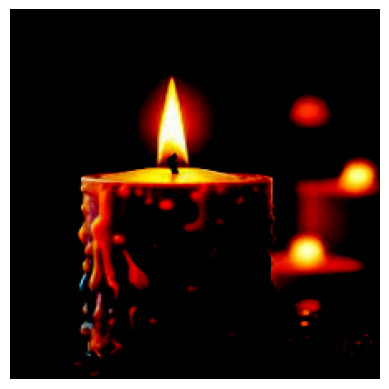

Caption: A taper candle is placed on a dinner table.
Target: 1


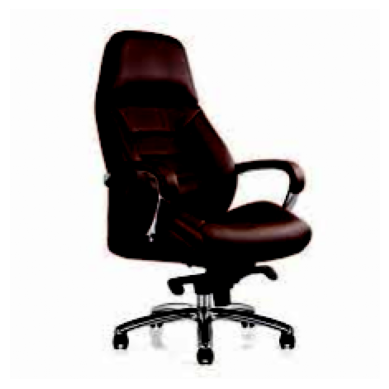

Caption: The coke spills over the edge of the cup.
Target: -1


In [ ]:
first_batch = next(iter(val_loader))

# Display the first image in the batch
image1 = first_batch['image'][0].permute(1, 2, 0).numpy()          # Convert to HWC format

plt.imshow(image1)
plt.axis('off')
plt.show()

print(f"Caption: {first_batch['caption'][0]}")
print(f"Target: {first_batch['target'][0]}")

# Display the second image in the batch
image2 = first_batch['image'][1].permute(1, 2, 0).numpy()

plt.imshow(image2)
plt.axis('off')
plt.show()

print(f"Caption: {first_batch['caption'][1]}")
print(f"Target: {first_batch['target'][1]}")


## Image Text Model

This model gives text and image embeddings

In [ ]:
## Failed experiments:
"""
        # Using GeLU and Tanh(Stagnant after acc-60%)
        # self.siamese_network = nn.Sequential(
        #     nn.Linear(embedding_dim, embedding_dim // 2),
        #     nn.GELU(),  # So no vanishing gradient
        #     nn.Linear(embedding_dim // 2, embedding_dim // 2),
        #     nn.Tanh(),  # So range is between [-1, 1]
        #     nn.Linear(embedding_dim // 2, embedding_dim),
        # )

        # Model deeper so it doesn't underfit(Went stagnant after acc-68%)
        # self.siamese_network = nn.Sequential(
        #   nn.Linear(embedding_dim, embedding_dim // 2),
        #   nn.GELU(),
        #   nn.Linear(embedding_dim // 2, embedding_dim // 2),
        #   nn.GELU(),
        #   nn.Linear(embedding_dim // 2, embedding_dim // 4),
        #   nn.Tanh(),
        #   nn.Linear(embedding_dim // 4, embedding_dim),
        # )

        # Goes stagnant after 13 epochs acc-74%
        # self.siamese_network = nn.Sequential(
        #   nn.Linear(embedding_dim, embedding_dim // 2),
        #   nn.BatchNorm1d(embedding_dim // 2),
        #   nn.GELU(),
        #   nn.Linear(embedding_dim // 2, embedding_dim // 2),
        #   nn.BatchNorm1d(embedding_dim // 2),
        #   nn.GELU(),
        #   nn.Linear(embedding_dim // 2, embedding_dim // 4),
        #   nn.BatchNorm1d(embedding_dim // 4),
        #   nn.Tanh(),
        #   nn.Linear(embedding_dim // 4, embedding_dim),
        # )

        # Applying dropout so overfitting does not occur(Model was not overfitting, resulted in decreased accuracy)
        # self.siamese_network = nn.Sequential(
        #   nn.Linear(embedding_dim, embedding_dim // 2),
        #   nn.BatchNorm1d(embedding_dim // 2),
        #   nn.GELU(),
        #   nn.Linear(embedding_dim // 2, embedding_dim // 2),
        #   nn.BatchNorm1d(embedding_dim // 2),
        #   nn.GELU(),
        #   nn.Linear(embedding_dim // 2, embedding_dim // 4),
        #   nn.BatchNorm1d(embedding_dim // 4),
        #   nn.Tanh(),
        #   nn.Linear(embedding_dim // 4, embedding_dim),
        # )

        # Increase model complexity
        # self.siamese_network = nn.Sequential(
        #   nn.Linear(embedding_dim, embedding_dim // 2),
        #   nn.BatchNorm1d(embedding_dim // 2),
        #   nn.GELU(),

        #   nn.Linear(embedding_dim // 2, embedding_dim // 2),
        #   nn.BatchNorm1d(embedding_dim // 2),
        #   nn.GELU(),

        #   nn.Linear(embedding_dim // 2, embedding_dim // 4),
        #   nn.BatchNorm1d(embedding_dim // 4),
        #   nn.GELU(),

        #   nn.Linear(embedding_dim // 4, embedding_dim // 3),
        #   nn.BatchNorm1d(embedding_dim // 3),
        #   nn.GELU(),

        #   nn.Linear(embedding_dim // 3, embedding_dim // 4),
        #   nn.BatchNorm1d(embedding_dim // 4),
        #   nn.Tanh(),

        #   nn.Linear(embedding_dim // 4, embedding_dim),
        # )
"""


In [ ]:
# Failed Experiment: Using ResNet 50 for image encoder. The model is still restricted by performance. Max acc ~ 75%
"""
import torch
import torch.nn as nn
import timm
from transformers import AutoModel

class ImageTextSiameseModel(nn.Module):
    def __init__(self, image_model_name='resnet50', text_model_name='bert-base-uncased', embedding_dim=1024):
        super(ImageTextSiameseModel, self).__init__()

        self.image_model = timm.create_model(image_model_name, pretrained=True)
        self.text_model = AutoModel.from_pretrained(text_model_name)

        # Second last layer of ResNet to remove other
        self.image_model = nn.Sequential(*list(self.image_model.children())[:-1])

        # Freeze pretrained models
        for param in self.image_model.parameters():
            param.requires_grad = False
        for param in self.text_model.parameters():
            param.requires_grad = False

        # ResNet's output = [batch_size, 2048, 1, 1],
        resnet_output_dim = 2048                                           # ResNet50 feature size
        self.image_projection = nn.Linear(resnet_output_dim, embedding_dim)
        self.text_projection = nn.Linear(self.text_model.config.hidden_size, embedding_dim)

        self.siamese_network = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim // 2),
            nn.BatchNorm1d(embedding_dim // 2),
            nn.GELU(),
            nn.Linear(embedding_dim // 2, embedding_dim // 2),
            nn.BatchNorm1d(embedding_dim // 2),
            nn.GELU(),
            nn.Linear(embedding_dim // 2, embedding_dim // 4),
            nn.BatchNorm1d(embedding_dim // 4),
            nn.Tanh(),
            nn.Linear(embedding_dim // 4, embedding_dim),
        )

    def forward(self, images, input_ids, attention_mask):
        # Generate image embeddings
        image_features = self.image_model(images)                         # [batch_size, 2048, 1, 1]
        image_features = image_features.view(image_features.size(0), -1)  # [batch_size, 2048]
        image_embeddings = self.image_projection(image_features)

        text_outputs = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        text_embeddings = text_outputs.last_hidden_state[:, 0, :]         # CLS token
        text_embeddings = self.text_projection(text_embeddings)

        image_embeddings = self.siamese_network(image_embeddings)
        text_embeddings = self.siamese_network(text_embeddings)

        return image_embeddings, text_embeddings
"""

In [ ]:
import torch
import torch.nn as nn
import timm
from transformers import AutoModel, ViTModel

class ImageTextSiameseModel(nn.Module):
    def __init__(self, image_model_name='google/vit-base-patch16-224', text_model_name='bert-base-uncased', embedding_dim=256):
        super(ImageTextSiameseModel, self).__init__()

        self.image_model = ViTModel.from_pretrained(image_model_name)  # Using ViT model
        self.text_model = AutoModel.from_pretrained(text_model_name)

        # Freeze pretrained models
        for param in self.image_model.parameters():
            param.requires_grad = False
        for param in self.text_model.parameters():
            param.requires_grad = False

        # Adjust final layers to output embeddings of size `embedding_dim`
        self.image_projection = nn.Linear(self.image_model.config.hidden_size, embedding_dim)
        self.text_projection = nn.Linear(self.text_model.config.hidden_size, embedding_dim)

        # Siamese network layers for further embedding transformation
        self.siamese_network = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim // 2),
            nn.BatchNorm1d(embedding_dim // 2),
            nn.GELU(),
            nn.Linear(embedding_dim // 2, embedding_dim // 2),
            nn.BatchNorm1d(embedding_dim // 2),
            nn.GELU(),
            nn.Linear(embedding_dim // 2, embedding_dim // 4),
            nn.BatchNorm1d(embedding_dim // 4),
            nn.Tanh(),
            nn.Linear(embedding_dim // 4, embedding_dim),
        )

    def forward(self, images, input_ids, attention_mask):
        # Generate image embeddings
        image_outputs = self.image_model(pixel_values=images)
        image_embeddings = self.image_projection(image_outputs.last_hidden_state[:, 0, :])  # CLS token

        # Generate text embeddings
        text_outputs = self.text_model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]
        text_embeddings = self.text_projection(text_outputs)

        # Pass both embeddings through the Siamese network layers
        image_embeddings = self.siamese_network(image_embeddings)
        text_embeddings = self.siamese_network(text_embeddings)

        return image_embeddings, text_embeddings

    def get_image_embeddings(self, images):
        """Generate embeddings for images only."""
        with torch.no_grad():
            image_outputs = self.image_model(pixel_values=images)
            image_embeddings = self.image_projection(image_outputs.last_hidden_state[:, 0, :])  # CLS token
            image_embeddings = self.siamese_network(image_embeddings)
        return image_embeddings

    def get_text_embeddings(self, input_ids, attention_mask):
        """Generate embeddings for text only."""
        with torch.no_grad():
            text_outputs = self.text_model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]
            text_embeddings = self.text_projection(text_outputs)
            text_embeddings = self.siamese_network(text_embeddings)
        return text_embeddings


## Cosine Similarity

The cosine similarity between two vectors \( x \) and \( z \) is given by $ \text{cos_sim}(x, z) = \frac{x \cdot z}{\|x\| \|z\|} $.

### Cosine Similarity Loss with \( y_i = 1 \) and \( y_i = -1 \)

The loss function for one sample is defined as:


$$
\text{loss}(x_1, x_2, y) =
\begin{cases}
1 - \cos(x_1, x_2) & \text{if } y = 1 \\
\max(0, \cos(x_1, x_2) - \text{margin}) & \text{if } y = -1
\end{cases}
$$

Where:
- \( x_1 \) is the first input vector (e.g., image embedding).
- \( x_2 \) is the second input vector (e.g., text embedding).
- \( y \) is the target label:
  - \( y = 1 \) means \( x_1 \) and \( x_2 \) are similar (positive pair).
  - \( y = -1 \) means \( x_1 \) and \( x_2 \) are dissimilar (negative pair).
- \( \cos(x_1, x_2) \) is the cosine similarity between vectors \( x_1 \) and \( x_2 \).
- \( \text{margin} \) is the margin value (default is 0.0). When \( y = -1 \), the loss function penalizes the cosine similarity between \( x_1 \) and \( x_2 \) if it's less than the margin, and the penalty is \( \max(0, \cos(x_1, x_2) - \text{margin}) \).

**Explanation**:
- For similar pairs (\( y_i = 1 \)), the second term minimizes distance to the margin \( m \).
- For dissimilar pairs (\( y_i = -1 \)), the first term minimizes the cosine similarity itself.




In [ ]:
# Example of usage:
model = ImageTextSiameseModel(embedding_dim=CONFIG["embedding_size"]).to(CONFIG["device"])
loss_fn = torch.nn.CosineEmbeddingLoss(margin=0.0)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Training Loop

In [ ]:
# Optimizer setup - Only train Siamese network layers
optimizer = optim.Adam(model.siamese_network.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

In [ ]:
# Function to calculate accuracy (similarity thresholding)
def calculate_accuracy(predicted_scores, labels, threshold=0.5):
    predicted_labels = (predicted_scores > threshold).float() * 2 - 1      # Convert to 1 or -1
    correct = (predicted_labels == labels).sum().item()
    accuracy = correct / len(labels)
    return accuracy

## Loading the model with parameters

In [ ]:
checkpoint_path = "/content/drive/MyDrive/model_fine_tune_epoch_6.pth"

# Initialize variables
epoch = 0
best_val_loss = float('inf')
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
epochs_without_improvement = 0
early_stop = False

# Attempt to load checkpoint if it exists
if os.path.isfile(checkpoint_path):
    try:
        checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        best_val_loss = checkpoint['best_val_loss']
        train_losses = checkpoint['train_losses']
        val_losses = checkpoint['val_losses']
        train_accuracies = checkpoint['train_accuracies']
        val_accuracies = checkpoint['val_accuracies']
        epochs_without_improvement = checkpoint['epochs_without_improvement']
        early_stop = checkpoint['early_stop']

        print(f"Checkpoint loaded. Resuming from epoch {epoch + 1}.")
    except Exception as e:
        print(f"Failed to load checkpoint: {e}. Starting from scratch.")
else:
    print("No checkpoint found. Starting from scratch.")


Checkpoint loaded. Resuming from epoch 6.


In [ ]:
from tqdm import tqdm

# Early stopping parameters
patience = 5                                                       # Number of epochs to wait before stopping
delta = 0.001                                                      # Minimum change to qualify as an improvement

# Training loop
for epoch in range(epoch, 25):
    if early_stop:
        print("Early stopping triggered.")
        break

    model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}", leave=False):
        images = batch['image'].to(CONFIG["device"])
        input_ids = batch['ids'].to(CONFIG["device"])
        attention_mask = batch['mask'].to(CONFIG["device"])
        labels = batch['target'].to(CONFIG["device"])

        # Forward pass: Get embeddings
        image_embeddings, text_embeddings = model(images, input_ids, attention_mask)

        # Calculate cosine similarity (predicted score)
        predicted_scores = torch.cosine_similarity(image_embeddings, text_embeddings)

        # Compute the loss using CosineEmbeddingLoss
        loss = loss_fn(image_embeddings, text_embeddings, labels)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update training metrics
        running_train_loss += loss.item()
        correct_train += ((predicted_scores * labels) > 0).sum().item()  # Correct predictions based on label match
        total_train += len(labels)

    avg_train_loss = running_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Validating Epoch {epoch+1}", leave=False):
            images = batch['image'].to(CONFIG["device"])
            input_ids = batch['ids'].to(CONFIG["device"])
            attention_mask = batch['mask'].to(CONFIG["device"])
            labels = batch['target'].to(CONFIG["device"])

            image_embeddings = nn.functional.normalize(image_embeddings, p=2, dim=1)
            text_embeddings = nn.functional.normalize(text_embeddings, p=2, dim=1)

            # Forward pass: Get embeddings
            image_embeddings, text_embeddings = model(images, input_ids, attention_mask)

            # Compute the loss
            loss = loss_fn(image_embeddings, text_embeddings, labels)

            # Calculate cosine similarity (predicted score)
            predicted_scores = torch.cosine_similarity(image_embeddings, text_embeddings)

            # Update validation metrics
            running_val_loss += loss.item()
            correct_val += ((predicted_scores * labels) > 0).sum().item()  # Correct predictions based on label match
            total_val += len(labels)

    avg_val_loss = running_val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # Print metrics for this epoch
    print(f"Epoch [{epoch + 1}/{CONFIG['epochs']}]")
    print(f"  Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy * 100:.2f}%")
    print(f"  Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy * 100:.2f}%")

    # Early stopping check
    if avg_val_loss < best_val_loss - delta:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        early_stop = True
        print(f"Stopping early at epoch {epoch + 1}")

    # Scheduler step
    scheduler.step(val_accuracy)

    checkpoint_path = f"/content/drive/MyDrive/model_fine_tune_epoch_{epoch + 1}.pth"
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),  # Save scheduler state
        'best_val_loss': best_val_loss,
        'best_val_accuracy': max(val_accuracies) if val_accuracies else 0.0,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'epochs_without_improvement': epochs_without_improvement,
        'early_stop': early_stop
    }, checkpoint_path)
    print(f"Checkpoint saved at {checkpoint_path}.")


Epoch [8/25]
  Training Loss: 0.0267, Training Accuracy: 93.16%
  Validation Loss: 0.0279, Validation Accuracy: 92.64%
Checkpoint saved at /content/drive/MyDrive/model_fine_tune_epoch_8.pth.


Epoch [9/25]
  Training Loss: 0.0247, Training Accuracy: 93.92%
  Validation Loss: 0.0252, Validation Accuracy: 93.85%
Checkpoint saved at /content/drive/MyDrive/model_fine_tune_epoch_9.pth.


KeyboardInterrupt: 

In [ ]:
print(f"Train Losses: {train_losses}")
print(f"Validation Losses: {val_losses}")
print(f"Train Accuracies: {train_accuracies}")
print(f"Validation Accuracies: {val_accuracies}")

Train Losses: [0.19246027575203004, 0.0841848989296976, 0.05934418230684089, 0.045625231422907496, 0.03756872321473592, 0.03432859559122571, 0.030447722663804237, 0.028727522711459622, 0.02667821027303207, 0.02468483653034928]
Validation Losses: [0.12840580001321375, 0.09906318388423141, 0.06835222901890473, 0.04717606970356131, 0.044580401852726936, 0.04029237888563348, 0.031192044908066794, 0.029218968305717772, 0.027850753299853936, 0.02521853692050339]
Train Accuracies: [0.7797847108191935, 0.8264459040321109, 0.849981755154169, 0.8774402481299033, 0.8992428388980113, 0.9142036124794746, 0.9202244116037219, 0.9262908228425469, 0.9315818281335523, 0.9391534391534392]
Validation Accuracies: [0.8237547892720306, 0.8414750957854407, 0.8381226053639846, 0.8836206896551724, 0.8877713920817369, 0.8916028097062579, 0.9126756066411239, 0.9219348659003831, 0.926404853128991, 0.9385376756066411]


# Testing

In [ ]:
from tqdm import tqdm
import torch
import torch.nn.functional as F

def test_model(model, test_loader, loss_fn, device):
    """
    Test the model on the test dataset.

    Args:
        model: Trained model.
        test_loader: DataLoader for the test dataset.
        loss_fn: Loss function used during testing.
        device: PyTorch device ('cpu' or 'cuda').

    Returns:
        dict: Contains test loss, accuracy, and other metrics.
    """
    model.eval()  # Set the model to evaluation mode
    running_test_loss = 0.0
    correct_test = 0
    total_test = 0

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing", leave=False):
            images = batch['image'].to(device)
            input_ids = batch['ids'].to(device)
            attention_mask = batch['mask'].to(device)
            labels = batch['target'].to(device)

            # Forward pass: Get embeddings
            image_embeddings, text_embeddings = model(images, input_ids, attention_mask)

            # Normalize embeddings
            image_embeddings = F.normalize(image_embeddings, p=2, dim=1)
            text_embeddings = F.normalize(text_embeddings, p=2, dim=1)

            # Calculate cosine similarity (predicted score)
            predicted_scores = torch.cosine_similarity(image_embeddings, text_embeddings)

            # Compute the loss
            loss = loss_fn(image_embeddings, text_embeddings, labels)

            # Update test metrics
            running_test_loss += loss.item()
            correct_test += ((predicted_scores * labels) > 0).sum().item()  # Correct predictions based on label match
            total_test += len(labels)

            # Save predictions and labels for analysis
            all_predictions.extend(predicted_scores.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute final metrics
    avg_test_loss = running_test_loss / len(test_loader)
    test_accuracy = correct_test / total_test

    print("\nTesting Results:")
    print(f"  Test Loss: {avg_test_loss:.4f}")
    print(f"  Test Accuracy: {test_accuracy * 100:.2f}%")

    return {
        "test_loss": avg_test_loss,
        "test_accuracy": test_accuracy,
        "predictions": all_predictions,
        "labels": all_labels,
    }

In [ ]:
loss_fn = torch.nn.CosineEmbeddingLoss(margin=0.0)

results = test_model(model, test_loader, loss_fn, CONFIG["device"])


Testing Results:
  Test Loss: 0.0336
  Test Accuracy: 91.19%


In [ ]:
print("Results for Epoch 6 which is giving the best results")

print(f"Test Loss: {results['test_loss']}")
print(f"Test Accuracy: {results['test_accuracy']}")
print(f"Predictions: {results['predictions']}")
print(f"Labels: {results['labels']}")

Results for Epoch 6 which is giving the best results
Test Loss: 0.03358540645021261
Test Accuracy: 0.9118773946360154
Predictions: [-0.18229148, 0.9755453, 0.9806136, -0.109881945, -0.10770042, -0.12980622, -0.1262852, 0.98703873, 0.9907768, -0.17419986, -0.053290397, -0.043517455, 0.97438645, -0.06973633, -0.084570825, -0.001928729, 0.9691246, -0.0432621, -0.07881393, -0.049067147, -0.13514078, 0.96499616, 0.9190853, -0.13380983, -0.049037714, -0.04430983, 0.9689375, -0.11050552, 0.9875263, -0.13842808, -0.11647849, -0.052196547, 0.9803349, 0.9873355, 0.9648799, 0.9647845, -0.09229645, 0.9185238, -0.12913314, 0.9844638, -0.027709834, -0.04350876, 0.9642595, 0.0032278001, -0.08111337, 0.98146605, 0.9553418, -0.089964814, -0.05950236, 0.98392856, -0.042626586, 0.9844743, 0.9657819, 0.97595394, 0.9562921, -0.086647674, -0.037986595, -0.09787215, 0.9880612, 0.9690258, 0.98056173, -0.08119261, -0.07836568, 0.98052925, 0.96427083, 0.9911623, -0.1253795, -0.08238449, -0.15768632, 0.9850367, 

# Results

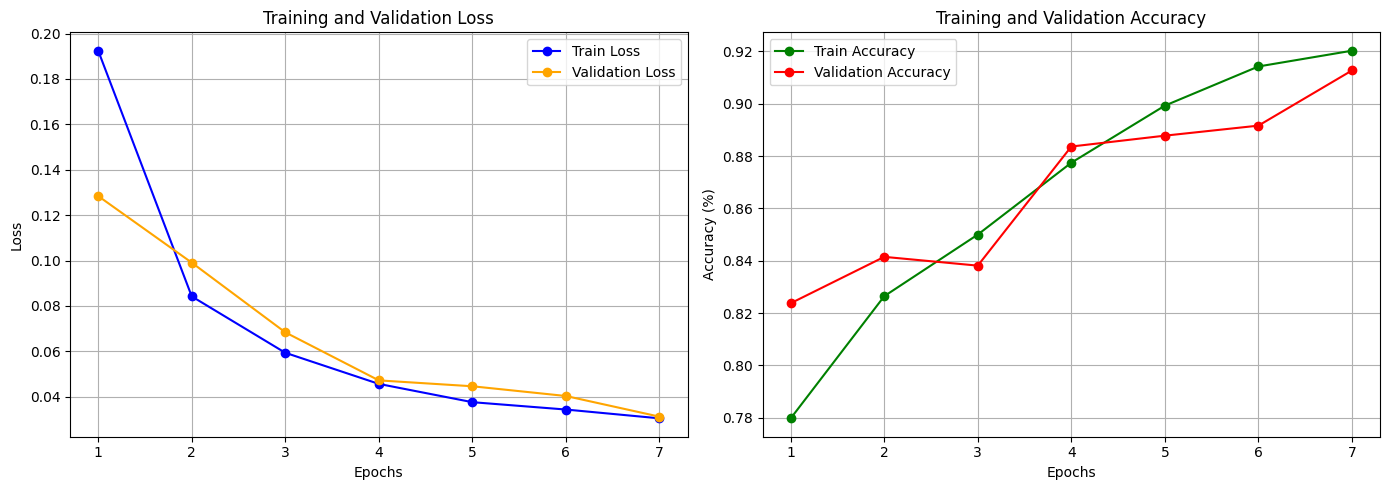

In [ ]:
import matplotlib.pyplot as plt

# Create subplots for losses and accuracies
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot losses
axes[0].plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", marker='o', color='blue')
axes[0].plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", marker='o', color='orange')
axes[0].set_title("Training and Validation Loss")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True)

# Plot accuracies
axes[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Train Accuracy", marker='o', color='green')
axes[1].plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Validation Accuracy", marker='o', color='red')
axes[1].set_title("Training and Validation Accuracy")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy (%)")
axes[1].legend()
axes[1].grid(True)

# Display the plots
plt.tight_layout()
plt.show()


## Checking for outputs

In [ ]:
import matplotlib.pyplot as plt
import random
import torch
from torch.utils.data import DataLoader
from torchvision import transforms


def show_image(image_tensor):
    """Convert image tensor to a displayable image and show it."""
    image = image_tensor.permute(1, 2, 0).cpu().numpy()  # Convert from CxHxW to HxWxC
    plt.imshow(image)
    plt.axis('off')
    plt.show()

def evaluate_random_samples(model, test_loader, device, num_samples=10):
    model.eval()  # Set model to evaluation mode

    # Get 10 random samples from the test_loader
    random.seed(69)
    random_indices = random.sample(range(len(test_loader.dataset)), num_samples)

    for idx in random_indices:
        # Get the sample from the dataset
        sample = test_loader.dataset[idx]
        image = sample['image'].unsqueeze(0).to(device)  # Add batch dimension and move to device
        input_ids = sample['ids'].unsqueeze(0).to(device)  # Add batch dimension and move to device
        attention_mask = sample['mask'].unsqueeze(0).to(device)
        description = sample['caption']

        # True label: 1 for similar, -1 for dissimilar
        true_score = sample['target'].item()

        # Forward pass: Get embeddings
        with torch.no_grad():
            image_embeddings, text_embeddings = model(image, input_ids, attention_mask)
            image_embeddings = nn.functional.normalize(image_embeddings, p=2, dim=1)
            text_embeddings = nn.functional.normalize(text_embeddings, p=2, dim=1)

        # Calculate cosine similarity between image and text embeddings
        cosine_sim = torch.cosine_similarity(image_embeddings, text_embeddings)

        # Display the result
        print(f"Sample {idx + 1}:")
        print(f"Description: {description}")
        print(f"True Score (Target): {true_score}")
        print(f"Predicted Cosine Similarity: {cosine_sim.item():.4f}")

        # Display the image
        show_image(sample['image'])

Sample 2803:
Description: A violin's bridge supports the strings above the body.
True Score (Target): -1
Predicted Cosine Similarity: 0.0449


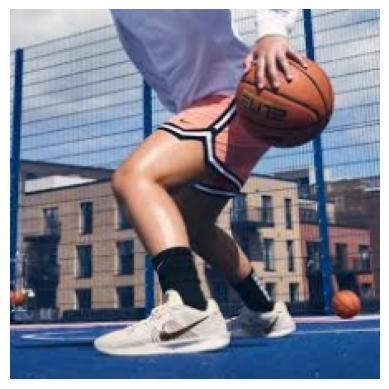

Sample 153:
Description: The dinosaur's scales shine in the sun.
True Score (Target): -1
Predicted Cosine Similarity: -0.0968


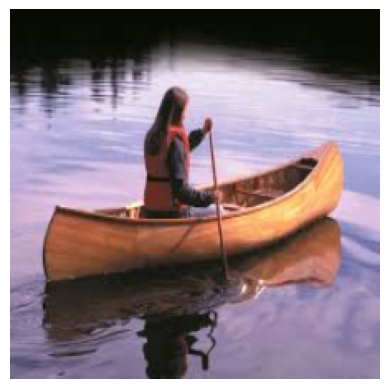

Sample 393:
Description: A cock stands in the middle of the farm.
True Score (Target): 1
Predicted Cosine Similarity: 0.9924


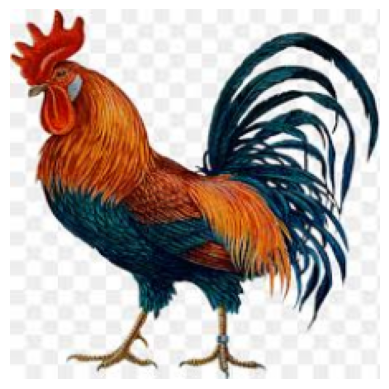

Sample 684:
Description: A basketball is thrown from the three-point line.
True Score (Target): 1
Predicted Cosine Similarity: 0.9914


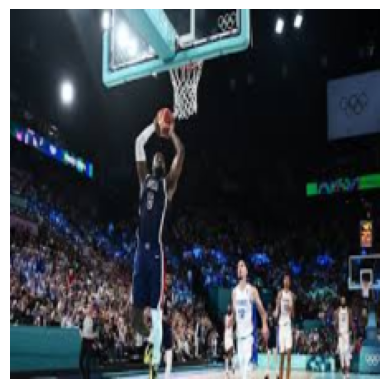

Sample 274:
Description: The crossword puzzle is lying on the table.
True Score (Target): -1
Predicted Cosine Similarity: -0.1042


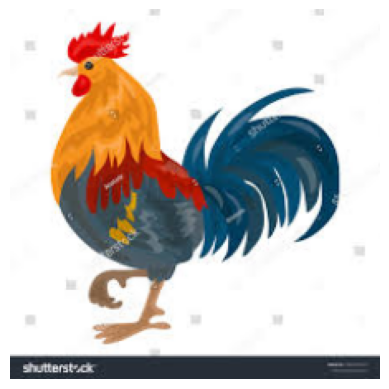

Sample 2479:
Description: The gorilla moves with powerful, deliberate steps.
True Score (Target): -1
Predicted Cosine Similarity: -0.0529


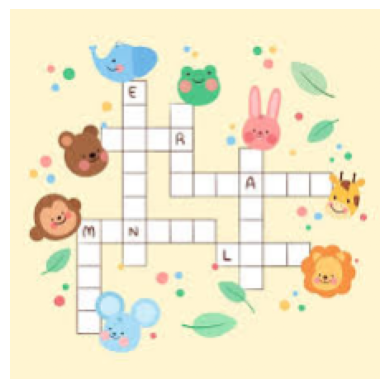

Sample 1412:
Description: The gorilla makes deep vocalizations.
True Score (Target): 1
Predicted Cosine Similarity: 0.9853


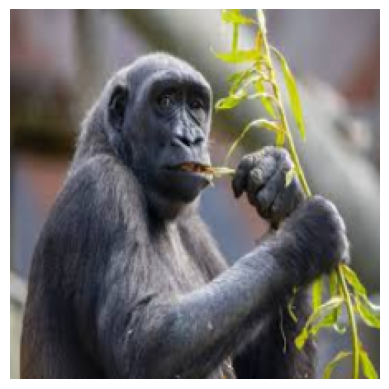

Sample 1344:
Description: A dinosaur's roar echoes through the valley.
True Score (Target): -1
Predicted Cosine Similarity: -0.2171


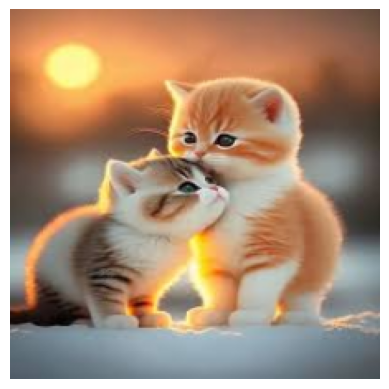

Sample 2250:
Description: A cold soda bottle sits on the table.
True Score (Target): -1
Predicted Cosine Similarity: 0.0037


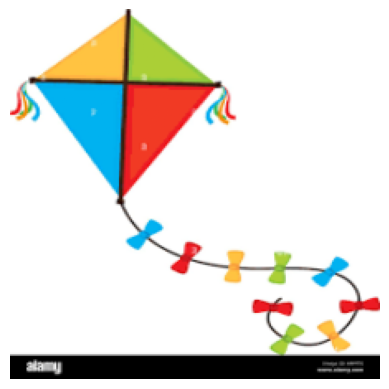

Sample 1698:
Description: The chair is used for sitting and relaxing.
True Score (Target): -1
Predicted Cosine Similarity: -0.1012


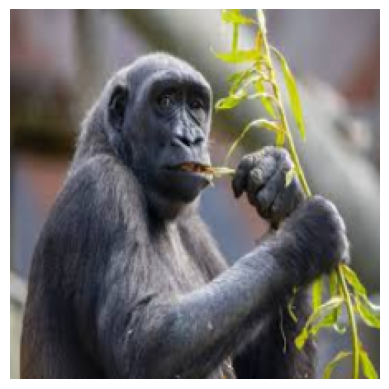

In [ ]:
evaluate_random_samples(model, test_loader, CONFIG["device"])

In [ ]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn.functional as F


def preprocess_text(tokenizer, text, max_length=128):
    """
    Preprocess text input for the model.

    Args:
        tokenizer: Tokenizer object from Hugging Face Transformers.
        text (str): Text description to preprocess.
        max_length (int): Maximum sequence length for tokenization.

    Returns:
        tuple: Tokenized input IDs and attention mask tensors.
    """
    encoding = tokenizer(
        text,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )
    return encoding['input_ids'].squeeze(0), encoding['attention_mask'].squeeze(0)


def show_image(image_tensor):
    """
    Convert an image tensor to a displayable image and show it.

    Args:
        image_tensor (torch.Tensor): Image tensor in shape (C, H, W).

    Returns:
        None: Displays the image.
    """
    # Convert tensor from CxHxW to HxWxC
    image = image_tensor.permute(1, 2, 0).cpu().numpy()

    # Clip to [0, 1] range for valid visualization
    image = (image - image.min()) / (image.max() - image.min())

    plt.imshow(image)
    plt.axis('off')
    plt.show()


def evaluate_random_samples(model, test_loader, device, num_samples=10):
    """
    Evaluate random samples from the test loader.

    Args:
        model: The image-text model.
        test_loader: DataLoader for test data.
        device: PyTorch device ('cpu' or 'cuda').
        num_samples (int): Number of samples to evaluate.

    Returns:
        None: Displays image, text, and cosine similarity scores.
    """
    model.eval()  # Set model to evaluation mode
    random.seed(69)

    # Randomly sample indices from the dataset
    random_indices = random.sample(range(len(test_loader.dataset)), num_samples)

    for idx in random_indices:
        # Fetch the sample from the dataset
        sample = test_loader.dataset[idx]
        image = sample['image'].unsqueeze(0).to(device)  # Add batch dimension
        input_ids = sample['ids'].unsqueeze(0).to(device)  # Add batch dimension
        attention_mask = sample['mask'].unsqueeze(0).to(device)
        description = sample['caption']
        true_score = sample['target'].item()

        # Forward pass
        with torch.no_grad():
            image_embeddings, text_embeddings = model(image, input_ids, attention_mask)
            image_embeddings = F.normalize(image_embeddings, p=2, dim=1)
            text_embeddings = F.normalize(text_embeddings, p=2, dim=1)

        # Cosine similarity
        cosine_sim = torch.cosine_similarity(image_embeddings, text_embeddings)

        # Display results
        print(f"Sample {idx + 1}:")
        print(f"Description: {description}")
        print(f"True Score (Target): {true_score}")
        print(f"Predicted Cosine Similarity: {cosine_sim.item():.4f}")

        # Show the image
        show_image(sample['image'])


from PIL import Image
import torch
import torch.nn.functional as F
from torchvision.transforms.functional import to_pil_image


def evaluate_single_sample(model, tokenizer, image_processor, image_path, text, device, max_length=128):
    """
    Evaluate a single image-text pair using the model.

    Args:
        model: The image-text model to evaluate.
        tokenizer: Tokenizer for text processing.
        image_processor: Image processor (e.g., ViTImageProcessor).
        image_path (str): Path to the input image.
        text (str): Input text description.
        device: PyTorch device ('cpu' or 'cuda').
        max_length (int): Maximum tokenization length.

    Returns:
        None: Displays the image and prints cosine similarity.
    """
    model.eval()  # Set the model to evaluation mode

    # Load and preprocess the image
    try:
        image = Image.open(image_path).convert("RGB")
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return

    # Preprocess image for ViT
    image = image_processor(images=image, return_tensors="pt")["pixel_values"].squeeze(0).to(device)
    show_image(image)

    # Tokenize the text description
    inputs = tokenizer.encode_plus(
        text,
        truncation=True,
        add_special_tokens=True,
        max_length=max_length,
        padding="max_length",
        return_tensors="pt"
    )
    input_ids = inputs["input_ids"].squeeze(0).to(device)
    attention_mask = inputs["attention_mask"].squeeze(0).to(device)

    # Forward pass
    with torch.no_grad():
        image_embeddings, text_embeddings = model(
            image.unsqueeze(0),  # Add batch dimension
            input_ids.unsqueeze(0),  # Add batch dimension
            attention_mask.unsqueeze(0)
        )
        # Normalize embeddings
        image_embeddings = F.normalize(image_embeddings, p=2, dim=1)
        text_embeddings = F.normalize(text_embeddings, p=2, dim=1)

    # Calculate cosine similarity
    cosine_sim = torch.cosine_similarity(image_embeddings, text_embeddings)

    # Display results
    print("Input Text Description:")
    print(f"{text}")
    print(f"\nPredicted Cosine Similarity: {cosine_sim.item():.4f}")



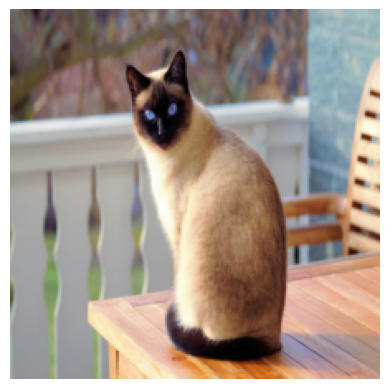

Input Text Description:
A cat walking

Predicted Cosine Similarity: 0.8674


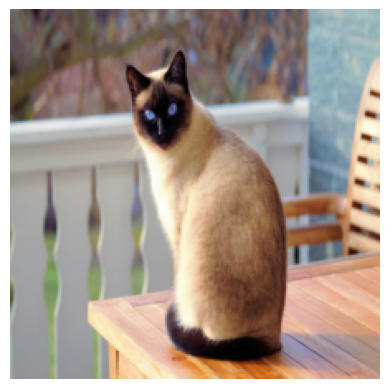

Input Text Description:
A wok being used for frying

Predicted Cosine Similarity: -0.0253


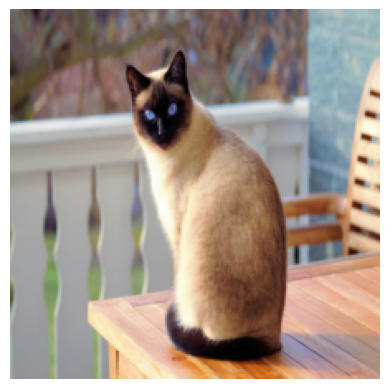

Input Text Description:
A basketball bouncing

Predicted Cosine Similarity: 0.1583


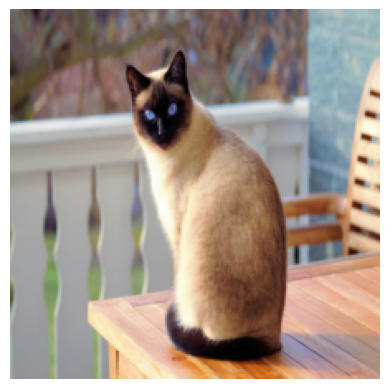

Input Text Description:
A gorilla eating bananas

Predicted Cosine Similarity: 0.2727


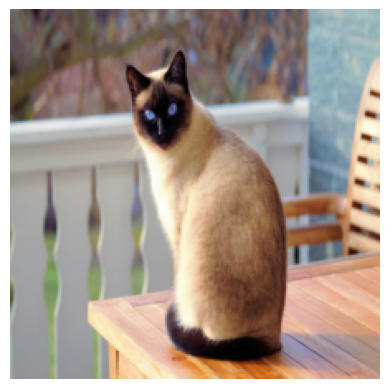

Input Text Description:
A violin being played

Predicted Cosine Similarity: 0.4180


In [ ]:
# # Load model and set to evaluation device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = ImageTextSiameseModel().to(device)


image_path = "/content/cat.jpg"
sample_text_1 = "A cat walking"
sample_text_2 = "A wok being used for frying"
sample_text_3 = "A basketball bouncing"
sample_text_4 = "A gorilla eating bananas"
sample_text_5 = "A violin being played"
evaluate_single_sample(model, tokenizer, image_processor, image_path, sample_text_1, CONFIG["device"])
evaluate_single_sample(model, tokenizer, image_processor, image_path, sample_text_2, CONFIG["device"])
evaluate_single_sample(model, tokenizer, image_processor, image_path, sample_text_3, CONFIG["device"])
evaluate_single_sample(model, tokenizer, image_processor, image_path, sample_text_4, CONFIG["device"])
evaluate_single_sample(model, tokenizer, image_processor, image_path, sample_text_5, CONFIG["device"])

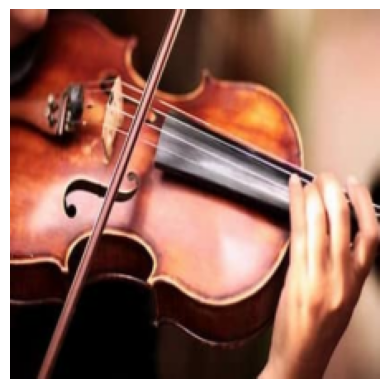

Input Text Description:
A cat walking

Predicted Cosine Similarity: -0.0801


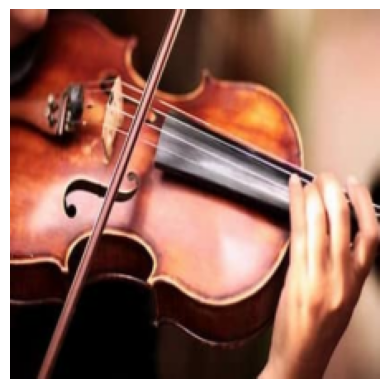

Input Text Description:
A wok being used for frying

Predicted Cosine Similarity: -0.1993


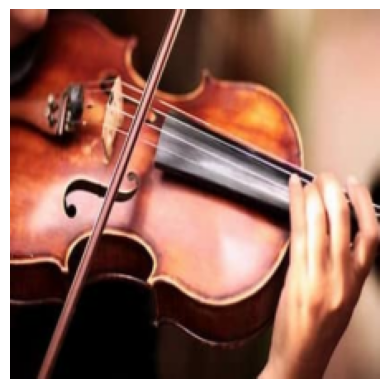

Input Text Description:
A basketball bouncing

Predicted Cosine Similarity: -0.2923


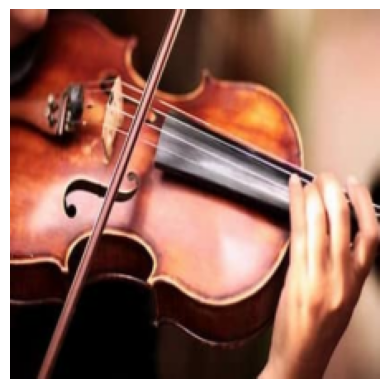

Input Text Description:
A gorilla eating bananas

Predicted Cosine Similarity: -0.2095


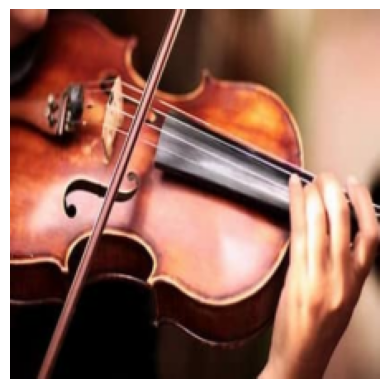

Input Text Description:
A violin being played

Predicted Cosine Similarity: 0.4604


In [ ]:
image_path = "/content/violin.jpg"
sample_text_1 = "A cat walking"
sample_text_2 = "A wok being used for frying"
sample_text_3 = "A basketball bouncing"
sample_text_4 = "A gorilla eating bananas"
sample_text_5 = "A violin being played"
evaluate_single_sample(model, tokenizer, image_processor, image_path, sample_text_1, CONFIG["device"])
evaluate_single_sample(model, tokenizer, image_processor, image_path, sample_text_2, CONFIG["device"])
evaluate_single_sample(model, tokenizer, image_processor, image_path, sample_text_3, CONFIG["device"])
evaluate_single_sample(model, tokenizer, image_processor, image_path, sample_text_4, CONFIG["device"])
evaluate_single_sample(model, tokenizer, image_processor, image_path, sample_text_5, CONFIG["device"])

# Saving Model

In [ ]:
# Save the traced model
torch.save(model, "/content/drive/MyDrive/image_text_siamese_model_full.pth")

In [ ]:
# Example image and text inputs (adjust shapes as needed)
example_image = torch.randn(1, 3, 224, 224).to(CONFIG["device"])  # Example image tensor
example_text_input = torch.randint(0, 1000, (1, 128)).to(CONFIG["device"])  # Example input_ids tensor
example_attention_mask = torch.ones(1, 128).to(CONFIG["device"])  # Example attention_mask tensor

# Trace the model with all required inputs
traced_model = torch.jit.trace(model, (example_image, example_text_input, example_attention_mask))

# Save the traced model
traced_model.save('/content/drive/MyDrive/image_text_siamese_traced_model.pt')


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])

In [ ]:
import torch

# Example inputs for tracing
example_image = torch.randn(2, 3, 224, 224).to(CONFIG["device"])  # Example image tensor with batch size of 2
example_input_ids = torch.randint(0, 1000, (2, 128)).to(CONFIG["device"])  # Example input_ids tensor with batch size of 2
example_attention_mask = torch.ones(2, 128).to(CONFIG["device"])  # Example attention_mask tensor with batch size of 2

# Define the inputs for the methods you want to trace
inputs = {
    'forward': (example_image, example_input_ids, example_attention_mask),
    'get_image_embeddings': example_image,
    'get_text_embeddings': (example_input_ids, example_attention_mask)
}

# Trace the entire model with the specific methods
traced_module = torch.jit.trace_module(model, inputs)

# Save the traced model
traced_module.save('/content/drive/MyDrive/siamese_traced_model.pt')


In [ ]:
traced_model = torch.jit.load('/content/drive/MyDrive/image_text_siamese_traced_model.pt')

In [ ]:
def evaluate_single_sample_image(model, image_processor, image_path, device):
    """
    Evaluate a single image-text pair using the model.

    Args:
        model: The image-text model to evaluate.
        tokenizer: Tokenizer for text processing.
        image_processor: Image processor (e.g., ViTImageProcessor).
        image_path (str): Path to the input image.
        text (str): Input text description.
        device: PyTorch device ('cpu' or 'cuda').
        max_length (int): Maximum tokenization length.

    Returns:
        None: Displays the image and prints cosine similarity.
    """
    model.eval()  # Set the model to evaluation mode

    # Load and preprocess the image
    try:
        image = Image.open(image_path).convert("RGB")
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return

    # Preprocess image for ViT
    image = image_processor(images=image, return_tensors="pt")["pixel_values"].squeeze(0).to(device)
    show_image(image)

    # Forward pass
    with torch.no_grad():
        image_embeddings = model.get_image_embeddings(image.unsqueeze(0))
        image_embeddings = F.normalize(image_embeddings, p=2, dim=1)

    print(image_embeddings)

In [ ]:
def evaluate_single_sample_text(model, tokenizer, text, device, max_length=128):
    """
    Evaluate a single image-text pair using the model.

    Args:
        model: The image-text model to evaluate.
        tokenizer: Tokenizer for text processing.
        image_processor: Image processor (e.g., ViTImageProcessor).
        image_path (str): Path to the input image.
        text (str): Input text description.
        device: PyTorch device ('cpu' or 'cuda').
        max_length (int): Maximum tokenization length.

    Returns:
        None: Displays the image and prints cosine similarity.
    """
    model.eval()  # Set the model to evaluation mode

    # Tokenize the text description
    inputs = tokenizer.encode_plus(
        text,
        truncation=True,
        add_special_tokens=True,
        max_length=max_length,
        padding="max_length",
        return_tensors="pt"
    )
    input_ids = inputs["input_ids"].squeeze(0).to(device)
    attention_mask = inputs["attention_mask"].squeeze(0).to(device)

    # Forward pass
    with torch.no_grad():
        # Normalize embeddings
        text_embeddings = model.get_text_embeddings(input_ids.unsqueeze(0), attention_mask.unsqueeze(0))
        text_embeddings = F.normalize(text_embeddings, p=2, dim=1)

    # Calculate cosine similarity
    # cosine_sim = torch.cosine_similarity(image_embeddings, text_embeddings)

    # Display results
    # print("Input Text Description:")
    # print(f"{text}")
    # print(f"\nPredicted Cosine Similarity: {cosine_sim.item():.4f}")
    print(text_embeddings)

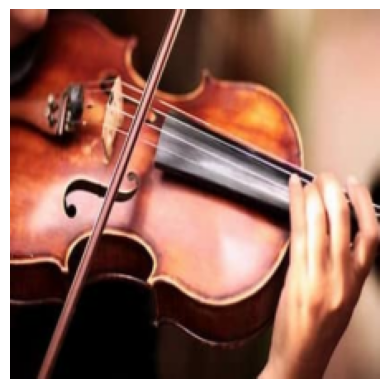

tensor([[ 0.0341,  0.0049,  0.0030,  ...,  0.0427, -0.0502, -0.0040]])
tensor([[-0.0365,  0.0027,  0.0601,  ..., -0.0260, -0.0334, -0.0070]])



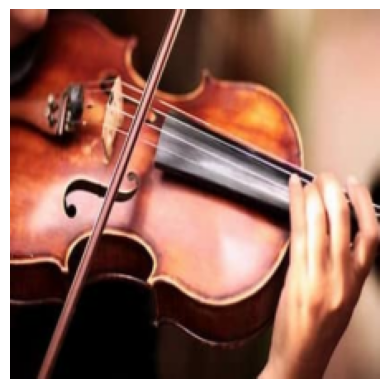

tensor([[ 0.0341,  0.0049,  0.0030,  ...,  0.0427, -0.0502, -0.0040]])
tensor([[-0.0043,  0.0213,  0.0440,  ...,  0.0167, -0.0184, -0.0020]])


In [ ]:
image_path = "/content/violin.jpg"
sample_text_1 = "A cat walking"
sample_text_2 = "A wok being used for frying"
sample_text_3 = "A basketball bouncing"
sample_text_4 = "A gorilla eating bananas"
sample_text_5 = "A violin being played"

evaluate_single_sample_image(model, image_processor, image_path, CONFIG["device"])
evaluate_single_sample_text(model, tokenizer, sample_text_1, CONFIG["device"])

print()

evaluate_single_sample_image(model, image_processor, image_path, CONFIG["device"])
evaluate_single_sample_text(model, tokenizer, sample_text_5, CONFIG["device"])